# NTDS Project

Team members: 
* Armand Boschin
* Bojana Ranković
* Quentin Rebjock

As a reminder, this is a reminder of the project proposal:

***Graph:*** Wikipedia hyperlink network

***Problem:*** Does the structure of the graph bears info on the content of the nodes ? We would like to find out if it is possible to detect communities of pages just by looking at the hyperlink connections and match these communities with real-world data such as categories of the pages.

***Steps of the project:***
* Scraping the Wikipedia hyperlink network. Start from one node and get the pages as far as 2 or 3 hops depending on the number of nodes we get.
* Try to apply spectral clustering in order to detect clusters of pages.
* Visualize the clusters to match them with real-world categories (using some of the tools from the last guest lecture).
* Model the network by a random graph/scale-free network/something else in order to try to retrieve some of its characteristics.
* Improve the community detection using for example the Louvain algorithm.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
import networkx as nx
import pickle

from scipy import sparse, linalg
from bs4 import BeautifulSoup

%matplotlib inline
warnings.simplefilter(action='ignore', category=UserWarning)

# 1) Data Acquisition

We want to acquire a sub-network of the Wikipedia hyperlink network. In such a graph, each node is a Wikipedia page and there is a link between node a and node b is there is a link to page b on page a. This is a directed network but we will make it undirected later on.

The process of the acquisition is the following : 
* Start from an arbitrary root node (prefer and ambiguous page in order to get as many different communities as possible).
* Explore the page to get the intra-wiki links and get first nodes.
* For each first node, explore the intra-wiki links to get the second nodes.

We chose to scrap directly the HTML code of wikipedia pages rather than using the standard Wikipedia API because this API cannot fetch disambiguation pages natively and those are some pages we are interrested in as the list a large variety of links (more on that later). 

Moreover, scraping the HTML code of pages is really easy and straigtforward when we are simply looking for intra wiki links.

On Wikipedia pages, all the links are contained in the following HTML structure of tags: 
```html
<li>
    <a href:''>
    </a>
</li>
```
This is what is used in the following function that finds the intra Wiki links on a given page.

In [ ]:
def find_inner_links(page_link):
    """
    :param page_link: url of the current page
    :return: list of the intra wiki urls contained in the current page
    """
    links = []
    # Get the HTML code of the page.
    soup = BeautifulSoup(requests.get('https://en.wikipedia.org'+page_link).text)
    # Look for all the <li> tags contained in the page.
    li_tags = soup.find_all('li')  
    for li_tag in li_tags:
        # Look for all the <li> tags contained the current <a> tag.
        a_tags = li_tag.find_all('a')
        for a_tag in a_tags:
            try:
                # Check if the current <a> tag is an intra wiki link.
                if '/wiki/' == a_tag['href'][0:6]:
                    links.append(a_tag['href'])
            except KeyError:
                # In this case the <a> tag is not a link.
                pass
    return links

We use as `root_node` the disambiguation page [Jaguar](https://en.wikipedia.org/wiki/Jaguar_(disambiguation) as it lists a really wide variety of themes (animals, cars, music, films, weapons...). The aim is to scrap pages from as many different communities as possible.

In [ ]:
root_node = '/wiki/Jaguar_(disambiguation)'

In [ ]:
neighbors = {}  # This dict stores for each page the list of its neighbors.

In [ ]:
first_nodes = set(find_inner_links(root_node))
neighbors[root_node] = first_nodes

In [ ]:
second_nodes = set()
for link in first_nodes:
    tmp = find_inner_links(link)
    neighbors[link] = tmp
    second_nodes = second_nodes.union(set(tmp))

Create the set of all nodes.

In [ ]:
nodes = first_nodes.union(second_nodes)
nodes.add(origin)

Look for connections between second nodes and the rest of the nodes.

In [ ]:
counter = 0
for link in second_nodes:
    counter += 1
    if counter % 100 == 0:
        print('{}/{}'.format(counter, len(second_nodes)))
    tmp = find_inner_links(link)
    neighbors[link] = list(set(tmp).intersection(nodes))

#### Creating pickle files

As the scraping of the network takes quite some time (especially getting the inner connections), we store the results in pickle files.

In [2]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_obj(nodes, 'nodes')
save_obj(first_nodes, 'first_nodes')
save_obj(second_nodes, 'second_nodes')
save_obj(neighbors, 'neighbors')

In [3]:
nodes = load_obj('nodes')
first_nodes = load_obj('first_nodes')
second_nodes = load_obj('second_nodes')
neighbors = load_obj('neighbors')

### Network creation

Let's convert the collected network into a networkx instance which is quite handy to manipulate.

Let's make it undirected as well.

In [4]:
g = nx.Graph(neighbors)

# 2) Data Exploration

In this part of the notebook, we provide some indicators of the data in order to understand what we'll be working on.

TODO: properties of the collected network

* Adjacency matrix
* Degrees distribution
* Average degree
* Diameter of the collected network
* (Pruning the collected network if necessary ?)
* Visualization of the network

In [5]:
print('Total number of nodes : {}'.format(len(nodes)))
print('Number of first nodes : {}'.format(len(first_nodes)))
print('Number of second nodes : {}'.format(len(second_nodes)))
print('Number of edges : {}'.format(np.sum([len(n) for n in neighbors.values()])))

Total number of nodes : 8745
Number of first nodes : 73
Number of second nodes : 8745
Number of edges : 859184


#### Adjacency Matrix

In [5]:
adj = nx.adjacency_matrix(g)

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)

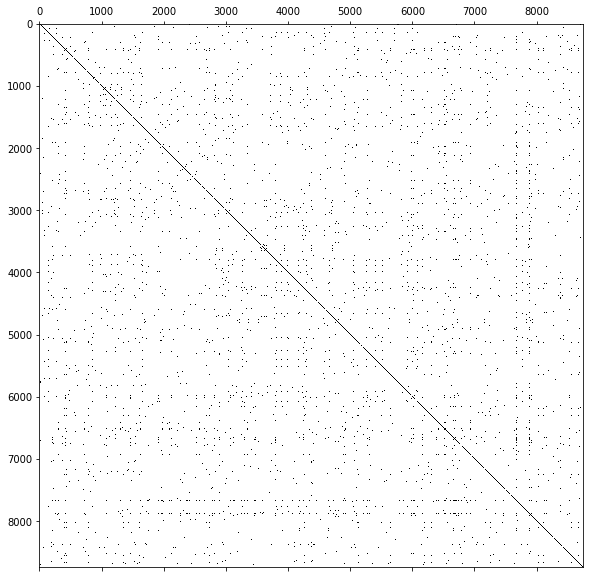

In [12]:
plt.spy(adj.todense())

Check if it's symmetric :

In [13]:
(adj != adj.T)

<8745x8745 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Degrees distribution

As there are some clear outliers making the visualization difficult, we can truncate the degrees or just use a box plot.

In [6]:
degrees = np.array(adj.sum(axis=1))
degrees_truncated = degrees[degrees < 700]

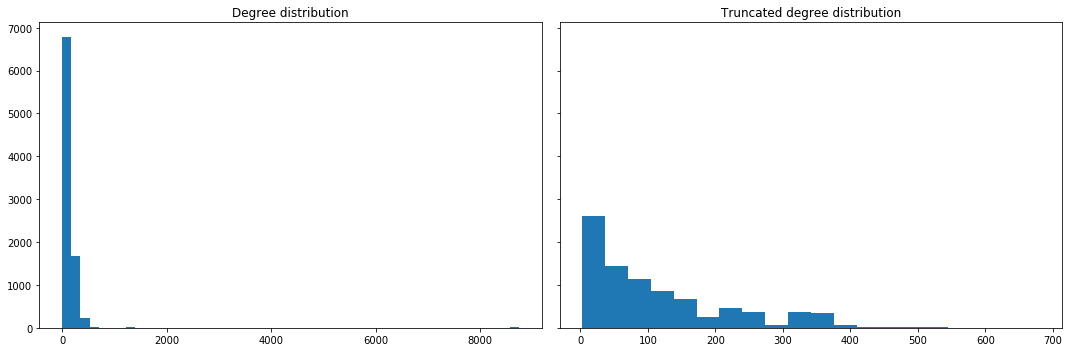

In [43]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree distribution')
#sns.distplot(degrees, bins=50, ax=ax[0, 0])
ax[0].hist(degrees, bins=50)

ax[1].set_title('Truncated degree distribution')
#sns.distplot(degrees_truncated, bins=20, ax=ax[0, 1])
ax[1].hist(degrees_truncated, bins=20)

plt.tight_layout()
plt.show()

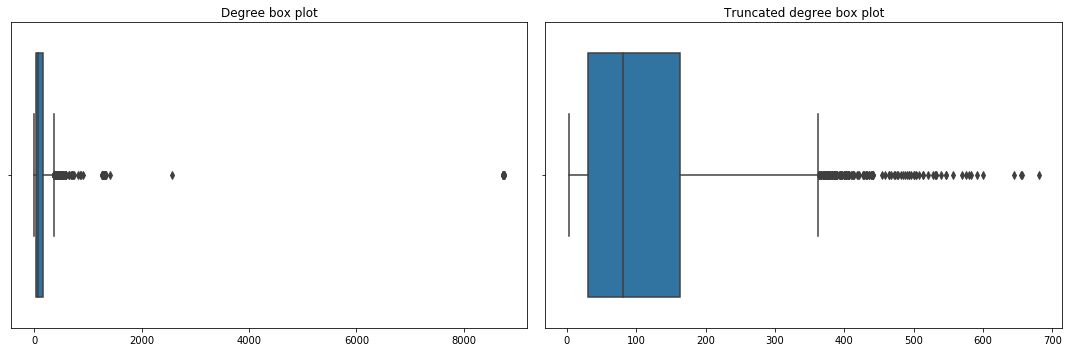

In [44]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree box plot')
sns.boxplot(degrees, ax=ax[0])

ax[1].set_title('Truncated degree box plot')
sns.boxplot(degrees_truncated, ax=ax[1])

plt.tight_layout()
plt.show()

#### Average degree

In [47]:
avg_degree = np.mean(degrees)
print('The average degree of the network is {}.'.format(np.round(avg_degree, 2)))

The average degree of the network is 133.41.


#### Diameter

In [ ]:
#Didn't end after 1 hour of computation...
diameter = nx.diameter(g)
print('The diameter of the network is {}.'.format(diameter))

#### Visualization

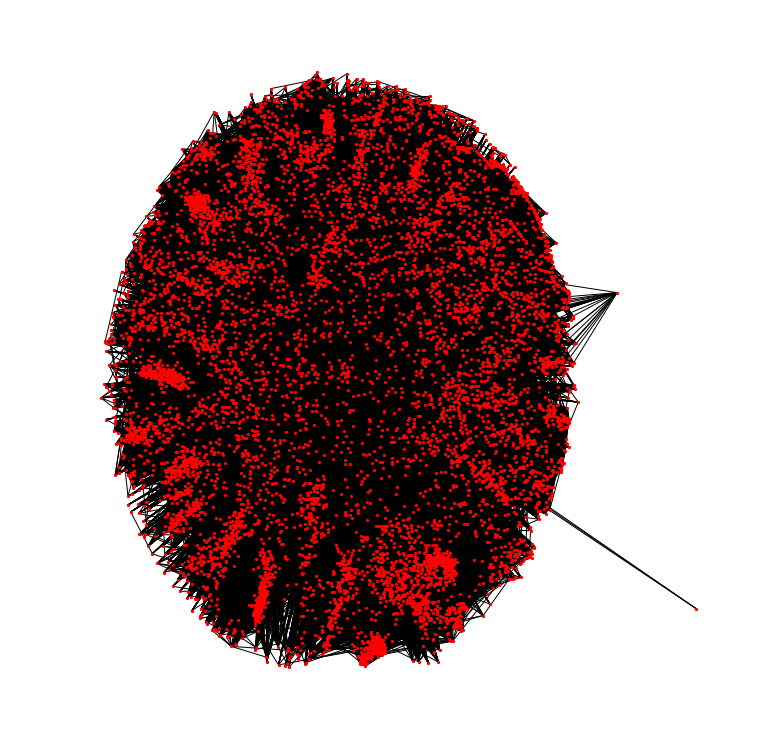

In [48]:
nx.draw(g, node_size=5)

# 3) Data Exploitation

We will try to use the collected data to answer our problem which is: 
 **Can we isolate communities of pages just by looking at the hyperlink graph ? **
 
The steps are the following :
 * Spectral clustering
 * Visualization of the communities
 * Modelization of the network
 * Improvement of the clustering ?
 
 
 * Visualize a random walk on the graph ? Signal processing on the graph. If we take a uniform signal (uniform distribution) and let the signal evolve randomly, what do we get ? Get we get hubs ?

## Spectral Clustering

In [61]:
laplacian = np.diag([int(d) for d in list(adj.sum(axis=1))]) - adj

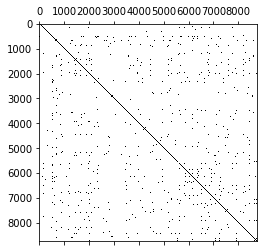

In [62]:
plt.spy(laplacian)

In [55]:
eigenvalues, eigenvectors = linalg.eigh(laplacian, eigvals=(0, 39))

In [57]:
centroids, labels = scipy.cluster.vq.kmeans2(eigenvectors, 40)

In [59]:
cc = [0 for i in range(40)]
for i in labels:
    cc[i] += 1

In [60]:
cc

[1,
 6,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 3,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 7,
 0,
 1,
 1,
 8692,
 1,
 3,
 0,
 1,
 3,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 3,
 3,
 1,
 0]

## Modelisation of the network

In this section, we are trying to model the collected network with a simpler one, trying to get the same principal features like the number of nodes, the number of edges, the degree distribution, the shape of the giant components, and so on. Such a model is particularly useful to understand the original network by working on a less complex structure.

### Exploration of the degree distribution

Let's first explore the original network distribution to see what kind of networks could fit. Here are two helper functions that will help later :

In [73]:
"""
Plot the degree distribution of a given networkx graph.
"""
def plot_degree_distr(graph, figsize=(15, 6), title='Degree distribution'):
    fig, ax = plt.subplots(figsize=figsize)
    
    d = list(dict(graph.degree()).values())
    sns.distplot(list(d), bins = 16, ax=ax);
    ax.set_ylabel('Number of vertices')
    ax.set_xlabel('Degree')
    ax.set_title(title)
    plt.show()

"""
Returns the degree distribution of a given networkx graph. The returned
value is an array whose k'th entry is the probability of a node to have
the degree k.
"""
def get_distribution(a):
    if type(a) == nx.classes.graph.Graph:
        probabilities = np.zeros(len(a) + 1)
        for k in nx.adjacency_matrix(a).sum(axis=1):
            probabilities[k] += 1
        probabilities = probabilities/np.sum(probabilities)
    return probabilities

In [8]:
nNodes = len(g.nodes())
nEdges = g.size()

min_degree = np.min(degrees)
max_degree = np.max(degrees)

print('The network has {0} nodes and {1} edges.'.format(nNodes, nEdges))

print('The minimum and the maximym degrees are respectively {0} and {1}.'.format(min_degree, max_degree))

The network has 8745 nodes and 587427 edges.
The minimum and the maximym degrees are respectively 3 and 8745.


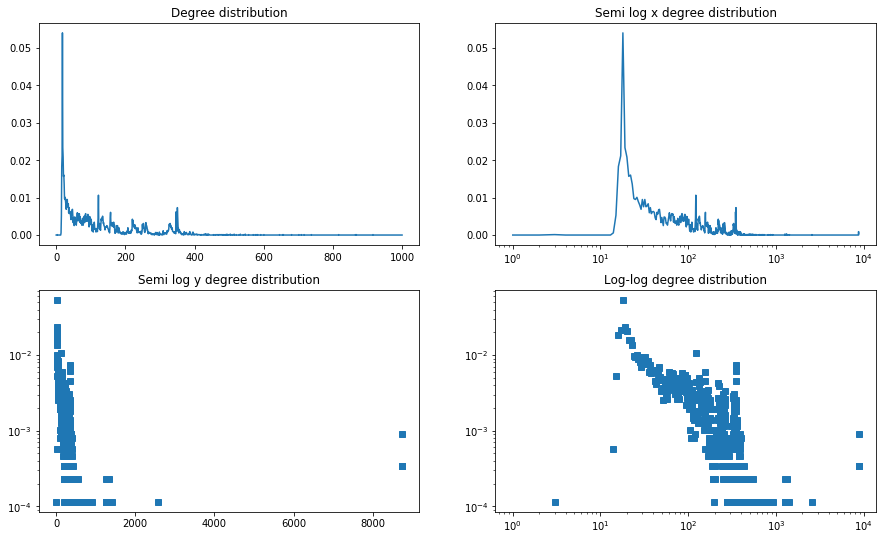

In [58]:
probability_distribution = get_distribution(g)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

ax[0, 0].set_title('Degree distribution')
ax[0, 0].plot(probability_distribution[:1000])

ax[0, 1].set_title('Semi log x degree distribution')
ax[0, 1].semilogx(probability_distribution)

ax[1, 0].set_title('Semi log y degree distribution')
ax[1, 0].semilogy(probability_distribution, 's')

ax[1, 1].set_title('Log-log degree distribution')
ax[1, 1].loglog(probability_distribution, 's')

The previous plots show that the degree distribution of the network is complicated and doesn't fit exactly any of the basic network structures studied during the semester. However the last log-log plot suggests that a scale-free network with a power law could approximate the distribution.

The best linear approximation is y = [[-1.13978356]]x + [-0.96789331].


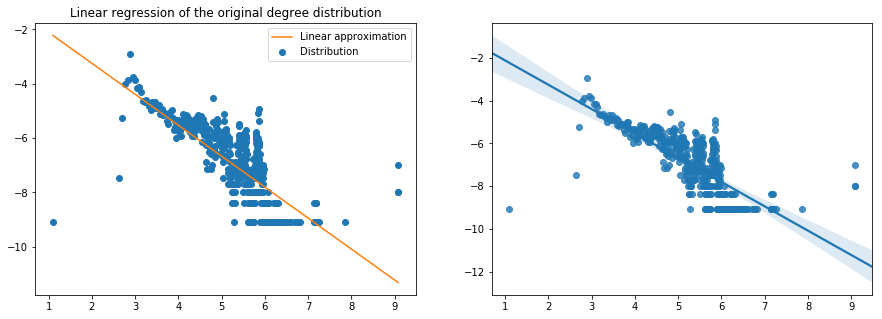

In [61]:
from sklearn import linear_model

x = np.where(probability_distribution != 0)[0]
y = probability_distribution[x]

logx = np.log(x).reshape(-1, 1)
logy = np.log(y).reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(logx, logy)

print('The best linear approximation is y = {0}x + {1}.'.format(regr.coef_, regr.intercept_))

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].scatter(logx, logy, color='C0', label='Distribution')
ax[0].plot(logx, regr.coef_*logx + regr.intercept_, color='C1', label='Linear approximation')
ax[0].set_title('Linear regression of the original degree distribution')
ax[0].legend(loc='upper right')

sns.regplot(logx, logy[:, 0], ax=ax[1]);

We will later use that regression to build an approximation of the network.

### Modelisation with basic network structures

#### Erdős–Rényi graph

The Erdős–Rényi graph models a random network where each pair of nodes has a fixed probability to be linked. We want this network to have the same number of nodes as the original one, and approximate the number of edges as much as possible.

In [64]:
p = 2*nEdges/nNodes/(nNodes - 1)

print('The probability hyper-parameter giving the best approximation of the number of edges is {}'.format(np.round(p, 4)))

The probability hyper-parameter giving the best approximation of the number of edges is 0.0154


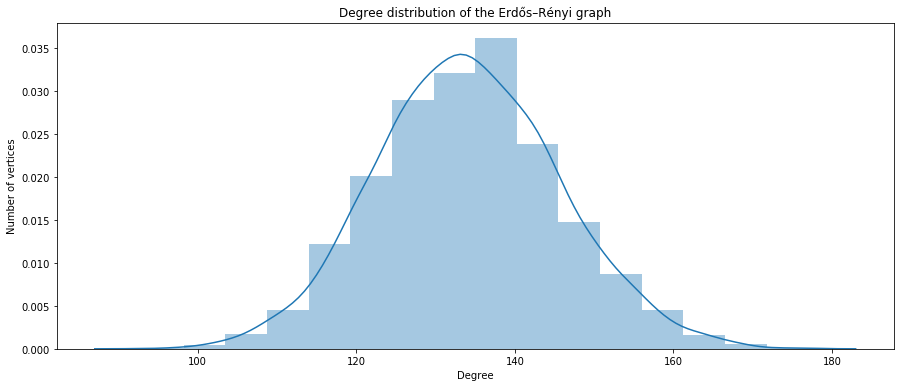

In [75]:
er = nx.erdos_renyi_graph(nNodes, p)

plot_degree_distr(er, title='Degree distribution of the Erdős–Rényi graph')

As expected, it clearly doesn't match the distribution of our network. The random networks have a Poisson degree distribution (when the number of nodes is large) and it doesn't fit to the observed distribution.

#### Barabási-Albert

The Barabási-Albert graph follows a power law distribution (in theory $p(k) = C*k^{-3}$) so we can hope much better results than with the random network modeling. The number of nodes that we want in the graph is fixed and we can only play with the parameter specifying the number of edges to attach from a new node to existing nodes. With the trial and error method, we found out that setting this parameter to 68 gives the closest number of edges to our original graph.

This Barabási-Albert network has 590036 edges while our original network has 587427 edges.


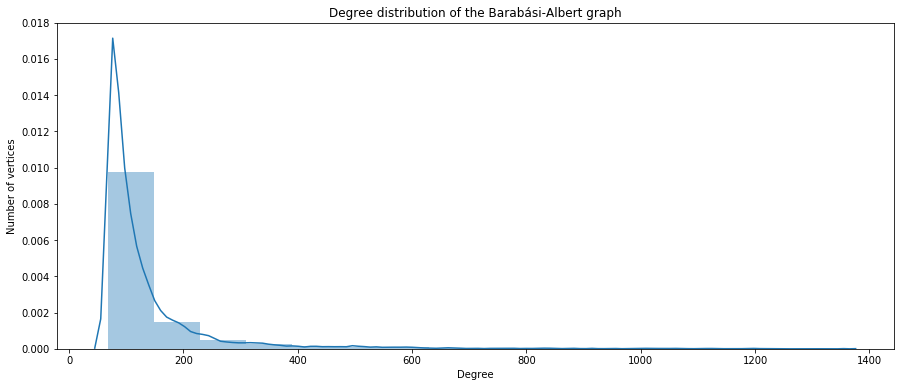

In [74]:
ba = nx.barabasi_albert_graph(nNodes, 68)

print('This Barabási-Albert network has {0} edges while our original network has {1} edges.'.format(ba.size(), nEdges))

plot_degree_distr(ba, title='Degree distribution of the Barabási-Albert graph')

It indeed seems to be a power law distribution. Let's have a deeper insight and try to measure the parameter of this power law (it should be 3 in theory).

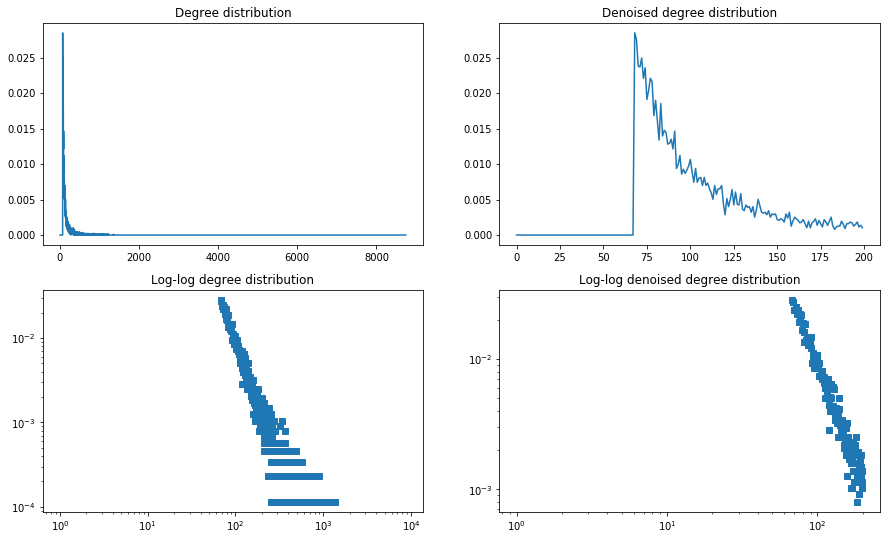

In [88]:
probability_distribution = get_distribution(ba)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

ax[0, 0].set_title('Degree distribution')
ax[0, 0].plot(probability_distribution)

ax[0, 1].set_title('Denoised degree distribution')
ax[0, 1].plot(probability_distribution[:200])

ax[1, 0].set_title('Log-log degree distribution')
ax[1, 0].loglog(probability_distribution, 's')

ax[1, 1].set_title('Log-log denoised degree distribution')
ax[1, 1].loglog(probability_distribution[:200], 's')

The best linear approximation is y = [[-3.00006911]]x + [ 9.08324495].


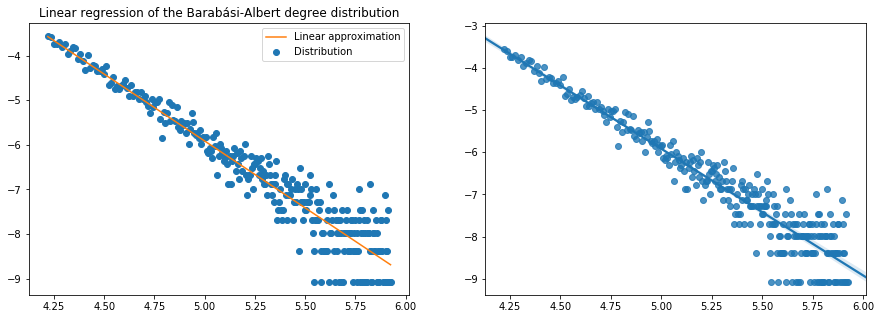

In [86]:
x = np.where(probability_distribution != 0)[0]
y = probability_distribution[x]

logx = np.log(x)
logy = np.log(y)

logx = logx[:300]
logy = logy[:300]

logx = logx.reshape(-1, 1)
logy = logy.reshape(-1, 1)

regr = linear_model.LinearRegression()

regr.fit(logx, logy)

print('The best linear approximation is y = {0}x + {1}.'.format(regr.coef_, regr.intercept_))

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].scatter(logx, logy, color='C0', label='Distribution')
ax[0].plot(logx, regr.coef_*logx + regr.intercept_, color='C1', label='Linear approximation')
ax[0].set_title('Linear regression of the Barabási-Albert degree distribution')
ax[0].legend(loc='upper right')

sns.regplot(logx, logy[:, 0], ax=ax[1]);

We get a coefficient very close to 3 (3.00006911) which is the expected value. Thus this network will be a better approximation than the random network precedently exposed but is still not ideal : we would like a power law network whose coefficient is closer to 1.13978356 as computed earlier.

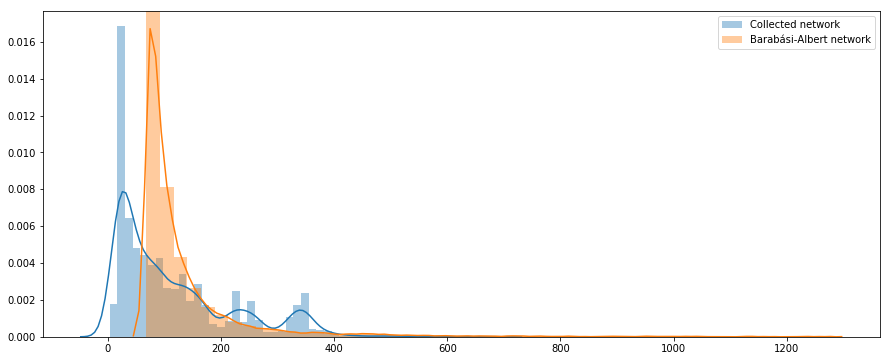

In [144]:
ba_degrees = list(dict(ba.degree()).values())

f, ax = plt.subplots(figsize=(15, 6))

sns.distplot(degrees_truncated, label='Collected network', ax=ax)
sns.distplot(ba_degrees, label='Barabási-Albert network', ax=ax)

plt.legend(loc='upper right')
plt.show()

We clearly see here that it is a better approximation but is still not ideal.

#### A power law network with the right exponent

In [ ]:
#HOW TO DO IT????

#### Giant components

In [ ]:
giant_g = max(nx.connected_component_subgraphs(g), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)

In [ ]:
print('The size of the giant components of the original, the Erdős–Rényi and the Barabási-Albert networks are '
      'respectively {0}, {1} and {2}'.format(len(giant_g.nodes()), len(giant_er.nodes()), len(giant_ba.nodes())))

In [ ]:
#ONE NODE IS FULLY CONNECTED TO ALL THE OTHER ONES !!!!!! IT WILL MAYBE CHANGE WITH THE NEW SCRAPPING

# 4) Conclusion